In [2]:
from astropy.io import fits
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
def gaussian(x, A, var, mu):
    return A * np.exp(-(x - mu)**2 / (2 * var))
def stas(data):
    return np.mean(data), stats.mode(data)[0][0], np.median(data), np.std(data)

# 4.1 Bias Frames

In [4]:
biases = sorted(glob.glob("data/ccd/*BIAS*"))
biases = list(map(fits.open, biases[:10]))

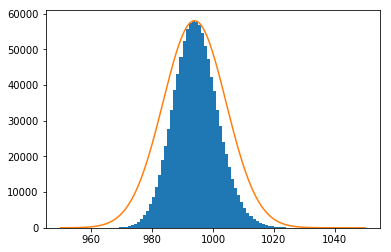

In [5]:
bias0 = biases[0][0]
bias0d = bias0.data.flatten()
bounds = 950, 1050
pmf, bins, _ = plt.hist(bias0d, bins=100, range=bounds);

avg0, mode0, med0, std0 = stas(bias0d)

x = np.linspace(*bounds, num=500)
gaussd = gaussian(x, max(pmf), std0**2, avg0)
plt.plot(x, gaussd);

In [6]:
nsd = np.abs((bias0d - avg0) / std0)
trimmed = bias0d[nsd < 3]

pct_bad = 100 * (1 - len(trimmed) / len(bias0d))
print("Q1 4.1")
print(f'The percent cut defined as 3 standard deviations away is: {pct_bad:.3f}%')

Q1 4.1
The percent cut defined as 3 standard deviations away is: 0.040%


In [7]:
elec_noise = bias0.header["EGAIN"] * std0
print("Our measured read noise is:",elec_noise)
print("Manufacturer's manual says 14.8 electrons of read noise. ")

Our measured read noise is: 21.334021034554155
Manufacturer's manual says 14.8 electrons of read noise. 


In [8]:
master_bias = sum([bias[0].data.flatten() for bias in biases]) / len(biases)

avg = np.mean(master_bias)
mode = stats.mode(master_bias)[0][0]
med = np.median(master_bias)
std = np.std(master_bias)

print("Q2 4.1")
print("standard deviation is {}".format(std0))
print("master standard deviation is {}".format(std))
print("This is a factor of {}".format(std/std0))
print("This is not quite {}".format(1/np.sqrt(10)))

Q2 4.1
standard deviation is 10.35632089056027
master standard deviation is 5.381477261079577
This is a factor of 0.5196321471638412
This is not quite 0.31622776601683794


In [9]:
HotBias = list(fits.open("data/ccd/m13.00000031.BIAS.FIT"))
HotBias1 = HotBias[0].data.flatten()

Hotavg, Hotmode, Hotmedian, Hotstd = stas(HotBias1)

trimmed_hot = np.abs((HotBias1-Hotavg)/Hotstd)
HotTrim = HotBias1[trimmed_hot < 3]
pct_bad_hot = 100 * (1 - len(HotTrim) / len(HotBias1))

print(f'The percent cut defined as 3 standard deviations away is: {pct_bad_hot:.3f}%')   
print(f'Compared to colder temperature from earlier: {pct_bad:.3f}%')

The percent cut defined as 3 standard deviations away is: 0.052%
Compared to colder temperature from earlier: 0.040%


# 4.2 Dark Frames

In [10]:
darks = sorted(glob.glob("data/ccd/*DARK*"))
darks = list(map(fits.open, darks[:]))

In [11]:
dark = []
for i in range(len(darks)):
    dark.append(darks[i][0].data.flatten())

In [12]:
Dark_Master = []
for j in range(len(dark[15])):
    tom = []
    for i in range(10):
        i = i+10   #account for only the dark frames where the time wasn't modified
        tom.append(dark[i][j])
    tom.sort
    Dark_Master.append(tom[4])
#do a median combine via sorting 

In [13]:
Davg, Dode, Ded, Dtd = stas(Dark_Master)
print("Average: {} \nMode: {} \nMedian: {} \nStandard Deviation: {} \n".format(Davg, Dode, Ded, Dtd))

Average: 1007.2209396362305 
Mode: 1004 
Median: 1004.0 
Standard Deviation: 124.63759864813386 



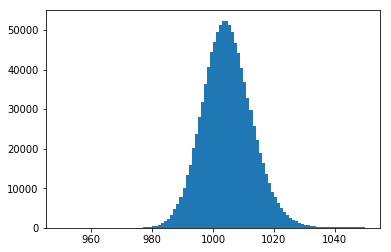

In [14]:
plt.hist(Dark_Master, bins = 100, range=bounds);

In [15]:
Dark_trim = np.abs(Dark_Master - Davg)/Dtd
Trimmed_Dark_Master = []
Hot_Pixel_Count = 0
for i in range(len(Dark_Master)):
    if Dark_trim[i] < 3:
        Trimmed_Dark_Master.append(Dark_Master[i])
    if Dark_Master[i] > 60000:
        Hot_Pixel_Count = Hot_Pixel_Count+1
pct_good_Dark = 100 * ( len(Trimmed_Dark_Master) / len(Dark_Master))
print("Fraction of pixels included in this cut:", pct_good_Dark)

Fraction of pixels included in this cut: 99.89795684814453


In [16]:
DTA, DTM, DTMe, DTS = stas(Trimmed_Dark_Master)
print("Average: {} \nMode: {} \nMedian: {} \nStandard Deviation: {} \n".format(DTA, DTM, DTMe, DTS))

Average: 1005.6241052557217 
Mode: 1004 
Median: 1004.0 
Standard Deviation: 15.503460990111815 



Standard Derviation changes the most due to the trimming because it goes from 124.6 to 15.5

Hot pixels are going to be from the Dark Master and the hot pxels will have counts above 60000

In [17]:
print("There are ", Hot_Pixel_Count, " Hot Pixels. I.e.", round(Hot_Pixel_Count/len(Dark_Master)*100,5), "percent", 
      "of the pixels are hot")

There are  2  Hot Pixels. I.e. 0.00019 percent of the pixels are hot


In [18]:
SDF = dark[11]
SDFA, SDFM, SDFMe, SDFS = stas(dark[0])
SDF_trim = np.abs(dark[0] - SDFA)/SDFS
SDFTrim = []
for i in range(len(SDF)):
    if SDF_trim[i] < 3:
        SDFTrim.append(SDF[i])
pct_good_SDF = 100 * ( len(SDFTrim) / len(SDF))
#SDF stands for single dark frame 

Going from a single dark frame to the master dark frame, the standard deviation increases and the amount of 
pixels thrown out also increases. 

In [19]:
print("Single Dark Frame Standard Deviation=",SDFS)
print("Master Dark Frame Standard Deviation=", Dtd) 
print("Percent of good data for single frame=",pct_good_SDF) 
print("Percent of good data for Master frame=",pct_good_Dark)

Single Dark Frame Standard Deviation= 81.84676429496206
Master Dark Frame Standard Deviation= 124.63759864813386
Percent of good data for single frame= 99.93791580200195
Percent of good data for Master frame= 99.89795684814453


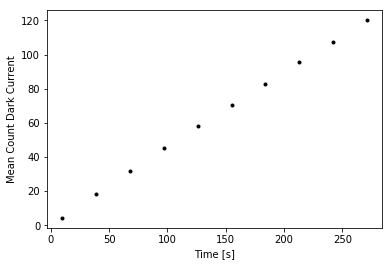

In [20]:
dark_red = [frame - master_bias for frame in dark]
dark_mean = [frame.mean() for frame in dark_red]
dark_mean = dark_mean[:10]

dark_std = [(frame.mean() / len(frame))**0.5 for frame in dark_red]
dark_std = dark_std[:10]

times = np.array([10,39,68,97,126,155,184,213,242,271])
plt.errorbar(times, dark_mean, yerr=dark_std, fmt="k.")
plt.xlabel("Time [s]")
plt.ylabel("Mean Count Dark Current");

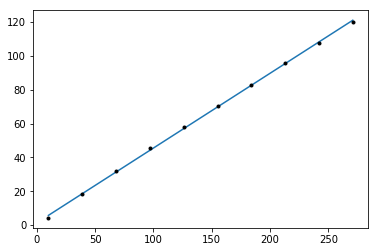

In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(times, dark_mean)
plt.errorbar(times, dark_mean, yerr=dark_std, fmt="k.")
plt.plot(times, slope * times + intercept);

In [22]:
print("Electrons per pixel per second:", slope)

Electrons per pixel per second: 0.4414221824398863


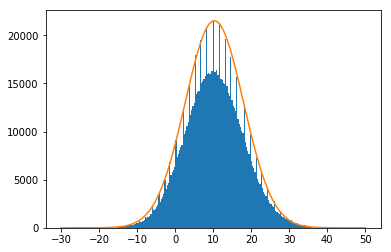

In [23]:
dark_master_red = Dark_Master - master_bias

med = np.median(dark_master_red)
num_sd = np.abs(dark_master_red - med) / med**0.5
dark_master_red = dark_master_red[num_sd < 10]

med = np.median(dark_master_red)
num_sd = np.abs(dark_master_red - med) / med**0.5
dark_master_red = dark_master_red[num_sd < 8]

pmf, bins, _ = plt.hist(dark_master_red, bins=250, range=(-30, 50));
x = np.linspace(-30, 50, num=250)
gauss = gaussian(x, max(pmf), dark_master_red.var(), dark_master_red.mean())
plt.plot(x, gauss);

In [24]:
HotDark = list(fits.open("data/ccd/m13.00000032.DARK.FIT"))
HotDarkData = HotDark[0].data.flatten()

hot_dark_red = HotDarkData - HotBias1
print(f"Hot Dark Current: {hot_dark_red.mean() / 30} electrons per pixel per second")

Hot Dark Current: 15.91317818959554 electrons per pixel per second


# 4.3 Flat Fields

I think the ones over to the left are deadzos?


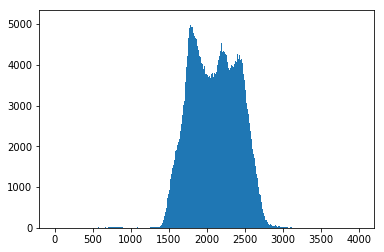

In [38]:
flats = sorted(glob.glob("data/flat/*"))
flats = list(map(fits.open, flats[:])) 
flat = []
for i in range(10):
    flat.append(flats[i][0].data.flatten())
    
master_flat_field = sum(flat[:])/10
plt.hist(master_flat_field, bins = 1000, range = (0,4000));
print("I think the ones over to the left are deadzos?")